### 7장 다양한 모델을 결합한 앙상블 학습
- 7.1 앙상블 학습
- 7.2 다수결 투표를 사용한 분류 앙상블
- 7.3 배깅: 부트스트랩 샘플링을 통한 분류 앙상블
- 7.4 약한 학습기를 이용한 에이다부스
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
## Iris dataset loading, labelEncoding, train/test spile
from sklearn import datasets 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder 

iris  = datasets.load_iris()
print(iris.data[50:55])
print(iris.target[50:55])
print('##########################################')

## setosa, versicolor, virginica가 각 50개씩 순서대로 있음 --> ROC AUG 계산을 위해 versicolor, virginica만 가져옴 
## versicolor, virginica의 라벨은 1, 2 --> LabelEncoder로 0, 1로 변경 
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

print(X[:5])
print(y[:5])
print('##########################################')

## train/test spile
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[[7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.9 1.5]
 [5.5 2.3 4.  1.3]
 [6.5 2.8 4.6 1.5]]
[1 1 1 1 1]
##########################################
[[3.2 4.7]
 [3.2 4.5]
 [3.1 4.9]
 [2.3 4. ]
 [2.8 4.6]]
[0 0 0 0 0]
##########################################
(50, 2)
(50, 2)
(50,)
(50,)


----
#### 1. 성능비교 : 10-fold vs. ensemble 
----

In [3]:
## 개별 모델들의 성능 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline 

clf1 = LogisticRegression(penalty = 'l2', C=0.001, random_state = 42)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 42)
clf3 = KNeighborsClassifier(n_neighbors = 1, p=2, metric = 'minkowski')

## clf1, clf3는 변수 표준화가 필요 
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

scores1 = cross_val_score(estimator = pipe1, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
scores2 = cross_val_score(estimator = clf2, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
scores3 = cross_val_score(estimator = pipe3, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')

print('ROC AUC : LogisticRegression = ', np.mean(scores1))
print('ROC AUC : DecisionTreeClassifier = ', np.mean(scores2))
print('ROC AUC : KNeighborsClassifier = ', np.mean(scores3))

ROC AUC : LogisticRegression =  0.9500000000000002
ROC AUC : DecisionTreeClassifier =  0.975
ROC AUC : KNeighborsClassifier =  0.8833333333333334


In [4]:
## ensemble 모델의 성능 
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier 

vc = VotingClassifier(estimators =[('LogisticRegression', pipe1),
                                   ('DecisionTreeClassifier', clf2),
                                   ('KNeighborsClassifier', pipe3)], 
                                   voting = 'soft')  ## voting = 'hard'이면 예측확률을 제공하지 않음. (ROC AUC 계산을 위해 예측확률 필요)

scores = cross_validate(estimator = vc, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
scores

{'fit_time': array([0.00500083, 0.0040009 , 0.0040009 , 0.00300074, 0.00400066,
        0.00399947, 0.00400186, 0.0040009 , 0.00499964, 0.0040009 ]),
 'score_time': array([0.00100017, 0.0010004 , 0.0010016 , 0.00100064, 0.00100327,
        0.00100017, 0.0010004 , 0.00200224, 0.00100017, 0.00100017]),
 'test_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [5]:
np.mean(scores['test_score'])

1.0

- 3개의 개별모델에 비해 앙상블 모델의 ROC AUC가 증가했음을 확인  

---- 
#### 2. GridSearchCV로 hyper-parameter 튜닝 
---- 

In [6]:
## logisticRegression : 매개변수 C, DecisionTreeClassifier : max_depth 
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV

stack = StackingClassifier(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression()) ## final_estimator : 최종 결정을 위한 분류기 지정

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

grid.fit(X_train, y_train)

print('- Best Parametors =', grid.best_params_)
print('- Best Scores =', grid.best_score_)

- Best Parametors = {'dt__max_depth': 1, 'lr__clf__C': 0.001}
- Best Scores = 1.0


- 최적의 변수 : 로지스틱의 규제 매개변수는 가장 낮을때인 0.001, 트리의 깊이는 1개 

----
#### 3. Bagging 
- train dataset에서 bootstrap sample(중복을 허용한 랜덤샘플)을 사용하여 학습 
- 랜덤 포레스트는 bagging의 특별한 경우에 해당 
- 모델의 분산을 감소하는 데는 효과적이나, 편항을 낮추는 데는 비효과적(*단순해서 데이터에 있는 경향을 잘 잡아내지 못함) 
- Bagging(랜덤포레스트 포함)을 사용할 때는, bootstrap sampling후 남는 데이터(OOB: Out Of Bag)가 있어, 별도 검증세트를 만들지 않고 이를 를 사용하여 검증함 
----

In [7]:
## wine 데이터셋 로딩, 전처리 
df_wine = pd.read_csv('data/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
print(df_wine.shape)
df_wine.head()

(178, 14)


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [8]:
## wine 데이터중 class 2, 3 + feature 'Alcohol', 'OD280/OD315 of diluted wines' 만 사용함 
df_wine = df_wine[df_wine['Class label'] != 1]
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values
print(X[:5], '\n', y[:5])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[[12.37  1.82]
 [12.33  1.67]
 [12.64  1.59]
 [13.67  2.46]
 [12.37  2.87]] 
 [2 2 2 2 2]
(95, 2)
(24, 2)
(95,)
(24,)


In [9]:
## tree와 BaggingClassifier를 사용한 100개 트리의 앙상블 학습결과 비교  
from sklearn.ensemble import BaggingClassifier 

tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth = None)
bag = BaggingClassifier(base_estimator = tree, 
                        n_estimators = 100,  ## default = 10 
                        max_samples = 1.0,   ## default
                        max_features = 1.0,  ## default
                        bootstrap = True, bootstrap_features = False, ## default
                        oob_score = True,  ## OOB 샘플을 사용한 검증 실행 
                        n_jobs = -1, random_state = 42)

In [10]:
tree.fit(X_train, y_train)
print('- Train accuracy of tree = ', tree.score(X_train, y_train))
print('- Test accuracy of tree = ', tree.score(X_test, y_test))

- Train accuracy of tree =  1.0
- Test accuracy of tree =  0.875


In [11]:
bag.fit(X_train, y_train)
print('- Train accuracy of bagging = ', bag.score(X_train, y_train))
print('- Test accuracy of bagging = ', bag.score(X_test, y_test))
print('- OOB accuracy of bagging = ', bag.oob_score_)

- Train accuracy of bagging =  1.0
- Test accuracy of bagging =  0.8333333333333334
- OOB accuracy of bagging =  0.8947368421052632


- 보통은 Bagging 결과가 overfitting이 좀더 줄어들어야 되는데, 여기서는 좀 이상하게 나왔음 ... 

In [12]:
## OOB (Out Of Bag) 데이터를 이용한 모델 검증 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(oob_score = True, random_state = 42) 
rf.fit(X_train, y_train)

print('-Train accuracy =', rf.score(X_train, y_train))
print('-Test accuracy =', rf.score(X_test, y_test))
print('-OOB accuracy =', rf.oob_score_)

-Train accuracy = 1.0
-Test accuracy = 0.875
-OOB accuracy = 0.8736842105263158


---- 
#### 4. Ada Boost 
- Bagging과 달리 Boosting은 중복하지 않고 train 데이터에서 랜덤샘플을 추출하여 훈련 
- 분류하기 어려운 샘플에 focus, 즉 이전 분류기에서 잘못 분류된 샘플에 가중치를 높게 부여하여 다음 분류기에서 훈련하는 과정 반복 
----

In [13]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth = 1)
ada = AdaBoostClassifier(base_estimator = tree, 
                         n_estimators = 100,  ## default = 10 
                         learning_rate = 0.1,
                         random_state = 42)

In [14]:
## depth = 1인 tree 
tree.fit(X_train, y_train)
print('- Train accuracy of tree = ', tree.score(X_train, y_train))
print('- Test accuracy of tree = ', tree.score(X_test, y_test))

- Train accuracy of tree =  0.9052631578947369
- Test accuracy of tree =  0.75


In [15]:
ada.fit(X_train, y_train)
print('- Train accuracy of Ada = ', bag.score(X_train, y_train))
print('- Test accuracy of Ada = ', bag.score(X_test, y_test))

- Train accuracy of Ada =  1.0
- Test accuracy of Ada =  0.8333333333333334


- depth = 1인 tree 대비, Ada의 모형정확도와 ovefitting 해소가 잘 이루어짐 

----
#### 5. 최신 boosting 기법들 
- GradientBoosting : 이전의 학습기가 만든 잔차오차(residual error)에 대한 학습기 추가 
- HistGradientBoosting : 특성을 256개 구간으로 나누어 학습함. (보통 샘플이 1만개 이상인 경우) 빠른 속도가 장점 
- Xgboost : 히스토그램 기반 부스팅의 한 방법 
- LightGBM : 히스토그램 기반 부스팅의 한 방법 
----

In [16]:
## Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier 
gbrt = GradientBoostingClassifier(n_estimators = 30, random_state = 42)
gbrt.fit(X_train, y_train)

print('- Train score of GB =', gbrt.score(X_train, y_train))
print('- Test score of GB =', gbrt.score(X_test, y_test))

- Train score of GB = 1.0
- Test score of GB = 0.8333333333333334


- ada boost는 100개의 트리를 사용, GB는 30개만 사용하여 동일한 결과 

In [17]:
## XGboost 
from xgboost import XGBClassifier 
xgbc = XGBClassifier(tree_method = 'hist', eval_metric = 'logloss', 
                    use_label_encoding = False, random_state = 42)
xgbc.fit(X_train, y_train)

print('- Train score of XGB =', xgbc.score(X_train, y_train))
print('- Test score of XGB =', xgbc.score(X_test, y_test))

[02:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "use_label_encoding" } are not used.

- Train score of XGB = 0.9789473684210527
- Test score of XGB = 0.875


<AxesSubplot:>

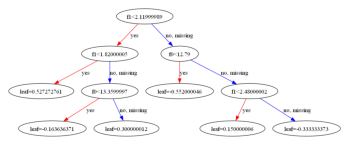

In [25]:
import xgboost as xgb
xgb.plot_tree(xgbc)

In [26]:
## LightGBM 
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state = 42)
lgbm.fit(X_train, y_train)

print('- Train score of LightGBM =', lgbm.score(X_train, y_train))
print('- Test score of LightGBM =', lgbm.score(X_test, y_test))

- Train score of LightGBM = 1.0
- Test score of LightGBM = 0.875
